In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score, roc_auc_score, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch
import os
from datetime import datetime
import pickle

In [3]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# Degree of overfitting on univariate toy datasest

The univariate toy datasets are used in (Abhineet et al. 2022) to visually compare the degree of overfitting of a single regression tree with and without HS applied. The authors present a linear and a non-linear case of the dataset where the target y is predicted from one noisy feature x. <br>
In this study we evaluate the degree of overfitting for random forest models instead of the single regression trees, as our artifact was primarily designed for random forest models and both versions of AugHS rely on the availability of OOB data. We fit the four models on the training dataset and let them predict on a separate test set. The predictions as well as the ground truth are then plotted in a line chart. A good model should ignore the noise in the training data so that its predictions closely resemble the ground truth. As the dataset only contains one informative feature, we expect both versions of AugHS to not induce an additional shrinkage penalty (m~1) and thus yield similar results to HsRF.

Code for simulation taken from this [notebook](https://github.com/Yu-Group/imodels-experiments/blob/master/notebooks/shrinkage/03_shrinkage_example.ipynb)

## Create function for experiment

In [19]:
def plot_sim(n=50, std=1, reg_param=0, reg_param_smSH=0, reg_param_MSE=0, linear_data=False, return_curves=False, gridsearch_lambda=False, ax=None):
    
    if ax == None:
        ax = plt.axes()
    
    np.random.seed(13)

    if linear_data:
        def gt_func(X):
            return X
    else:
        def gt_func(X):
            return +1 * (X < 2) * (X < 1) + \
                   -0 * (X < 2) * (X > 1) + \
                   +1 * (X >= 2) * (X < 3) + \
                   +0 * (X >= 2) * (X > 3)

    # data to fit
    X = np.random.uniform(0, 4, n)
    X = np.sort(X)
    y = gt_func(X) + np.random.normal(0, 1, n) * std

    # data to plot
    X_tile = np.linspace(0, 4, 400)
    y_tile = gt_func(X_tile)

    # Regular RF model
    rf = RandomForest(n_trees=100, treetype="regression", random_state=1)
    rf.fit(X.reshape(-1,1), y.reshape(-1,1))
    y_pred_rf = rf.predict(X_tile.reshape(-1,1))
    
    # HsRF with predefined lambda (as in original paper)
    hsRF = RandomForest(n_trees=100, treetype="regression", HShrinkage=True, HS_lambda=reg_param, random_state=1)
    hsRF.fit(X.reshape(-1,1), y.reshape(-1,1))
    y_pred_shrunk = hsRF.predict(X_tile.reshape(-1, 1))

    grid = {"HS_lambda":[0.1,1,10,25,50,100]} 

    # AugHsRF smSHAP
    if gridsearch_lambda:
        hsRF_smSH = RandomForest(n_trees=100, treetype="regression", HS_lambda=reg_param, oob=True, oob_SHAP=True, HS_smSHAP=True, random_state=1)
        hsRF_smSH_cv = GridSearchCV_scratch(hsRF_smSH, grid, X.reshape(-1,1), y.reshape(-1,1), 3, r2_score)
        print("GridSearch AugHsRF smSHAP completed")
    else:
        hsRF_smSH = RandomForest(n_trees=100, treetype="regression", HS_lambda=reg_param_smSH, oob=True, oob_SHAP=True, HS_smSHAP=True, random_state=1)
        hsRF_smSH.fit(X.reshape(-1,1), y.reshape(-1,1))
    y_pred_shrunksmSHAP = hsRF_smSH.predict(X_tile.reshape(-1, 1))

    # AugHsRF MSE
    if gridsearch_lambda:
        hsRF_MSE = RandomForest(n_trees=100, treetype="regression", oob=True, HS_nodewise_shrink_type="MSE_ratio", random_state=1)
        hsRF_MSE_cv = GridSearchCV_scratch(hsRF_MSE, grid, X.reshape(-1,1), y.reshape(-1,1), 3, r2_score)
        print("GridSearch AugHsRF MSE completed")
    else:
        hsRF_MSE = RandomForest(n_trees=100, treetype="regression", oob=True, HS_lambda=reg_param_MSE, HS_nodewise_shrink_type="MSE_ratio", random_state=1)
        hsRF_MSE.fit(X.reshape(-1,1), y.reshape(-1,1))
    y_pred_nodewise= hsRF_MSE.predict(X_tile.reshape(-1,1))
    
    # Create plots
    ax.plot(X, y, 'o', color='black', ms=4, alpha=0.5, markeredgewidth=0) # train samples
    ax.plot(X_tile, y_tile, label='Groundtruth', color='black', lw=3) # groundtruth
    ax.plot(X_tile, y_pred_rf, '-', label='RF', alpha=0.5, lw=4) 
    ax.plot(X_tile, y_pred_shrunk, label=f'HsRF (λ={hsRF.HS_lambda})', alpha=0.6, lw=4)
    ax.plot(X_tile, y_pred_shrunksmSHAP, label=f'AugHsRF smSHAP (λ={hsRF_smSH.HS_lambda})', alpha=0.6, lw=4)
    ax.plot(X_tile, y_pred_nodewise, label=f'AugHsRF MSE (λ={hsRF_MSE.HS_lambda})', alpha=0.6, lw=4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

    if linear_data:
        ax.set_title('Linear data')
    else:
        ax.set_title('Non-linear data')

    if return_curves:
        results = {"data":{
                        "n":n,
                        "std":std,
                        "linear_data": linear_data,
                        "X":X, 
                        "y":y, 
                        "X_tile":X_tile, 
                        "y_tile":y_tile},
                    "RF":{
                        "model": rf,
                        "y_pred": y_pred_rf
                    },
                    "hsRF":{
                        "model": hsRF,
                        "y_pred": y_pred_shrunk,
                        "lambda": reg_param
                    },
                    "AugHsRF_smSHAP":{
                        "model": hsRF_smSH,
                        "y_pred": y_pred_shrunksmSHAP,
                        "lambda": hsRF_smSH.HS_lambda
                    },
                    "AugHsRF_MSE":{
                        "model": hsRF_MSE,
                        "y_pred": y_pred_nodewise,
                        "lambda": hsRF_MSE.HS_lambda
                    },
                    "random_state":1,
                    "fig":plt.gcf()}
        if gridsearch_lambda:
            results["AugHsRF_smSHAP"]["cv"] = hsRF_smSH_cv
            results["AugHsRF_MSE"]["cv"] = hsRF_MSE_cv
        
        return results

## Run experiment

Please note that we pre-defined the regularization parameter based on the results of a previous run of the experiment. to minimize computation time. The original GridSearch results can be found in the `data` folder. 

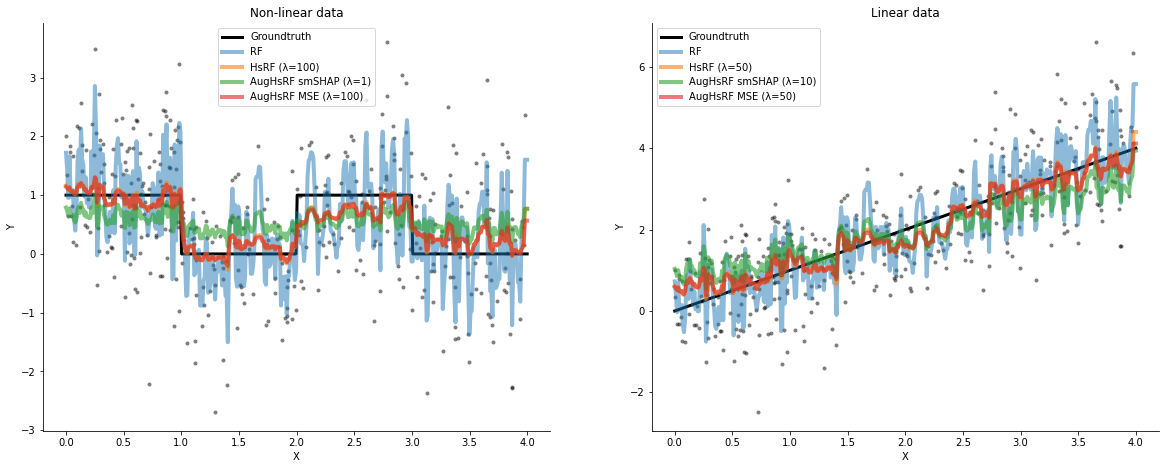

In [20]:
# Run experiment and create plots
fig, axs = plt.subplots(1,2, figsize=(20,7.5))

results_nonlin = plot_sim(
    n=400, std=1, reg_param=100, ax=axs[0], return_curves=True, gridsearch_lambda=False, reg_param_smSH=1, reg_param_MSE=100)
results_lin = plot_sim(
    n=400, std=1, reg_param=50, linear_data=True, ax=axs[1], return_curves=True, gridsearch_lambda=False, reg_param_smSH=10, reg_param_MSE=50)

In [21]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","HS_toyunivariate")
today_str = datetime.today().strftime("%Y%m%d")

# store results
with open(f'{data_path}/{today_str}_DegrOverFit_results_nonlin.pickle', 'wb') as handle:
    pickle.dump(results_nonlin, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{data_path}/{today_str}_DegrOverFit_results_lin.pickle', 'wb') as handle:
    pickle.dump(results_lin, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Save figure
fig.savefig(f"{data_path}/{today_str}_DegrOverFit_plots.png")

## Predictive performance

### Non-linear data

In [22]:
X = results_nonlin["data"]["X"].reshape(-1,1)
y = results_nonlin["data"]["y"].reshape(-1,1)
X_tile = results_nonlin["data"]["X_tile"].reshape(-1,1)
y_tile = results_nonlin["data"]["y_tile"]
y_pred_RF = results_nonlin["RF"]["y_pred"]
y_pred_HS = results_nonlin["hsRF"]["y_pred"]
y_pred_smSH = results_nonlin["AugHsRF_smSHAP"]["y_pred"]
y_pred_nodewise = results_nonlin["AugHsRF_MSE"]["y_pred"]
hsRF = results_nonlin["hsRF"]["model"]
hsRF_smSH = results_nonlin["AugHsRF_smSHAP"]["model"]
hsRF_MSE = results_nonlin["AugHsRF_MSE"]["model"]

In [23]:
# Compare MSE
print("MSE RF:", round(mean_squared_error(y_tile, y_pred_RF),2))
print("MSE hsRF:", round(mean_squared_error(y_tile, y_pred_HS),2))
print("MSE AugHsRF smSHAP:", round(mean_squared_error(y_tile, y_pred_smSH),2))
print("MSE AugHsRF MSE:", round(mean_squared_error(y_tile, y_pred_nodewise),2))

MSE RF: 0.41
MSE hsRF: 0.06
MSE AugHsRF smSHAP: 0.18
MSE AugHsRF MSE: 0.06


In [24]:
# Check smoothing coef for AugHsRF_smSHAP
coefs = np.abs(hsRF_smSH.smSHAP_coefs)[0]
print(f"AugHsRF smSHAP with λ={hsRF_smSH.HS_lambda} and additional smoothing multiplier m={round(coefs,2)}")

AugHsRF smSHAP with λ=1 and additional smoothing multiplier m=0.21


### Linear data

In [25]:
X = results_lin["data"]["X"].reshape(-1,1)
y = results_lin["data"]["y"].reshape(-1,1)
X_tile = results_lin["data"]["X_tile"].reshape(-1,1)
y_tile = results_lin["data"]["y_tile"]
y_pred_RF = results_lin["RF"]["y_pred"]
y_pred_HS = results_lin["hsRF"]["y_pred"]
y_pred_smSH = results_lin["AugHsRF_smSHAP"]["y_pred"]
y_pred_nodewise = results_lin["AugHsRF_MSE"]["y_pred"]
hsRF_smSH = results_lin["AugHsRF_smSHAP"]["model"]
hsRF_MSE = results_lin["AugHsRF_MSE"]["model"]

In [26]:
# Compare MSE
print("MSE RF:", round(mean_squared_error(y_tile, y_pred_RF),2))
print("MSE hsRF:", round(mean_squared_error(y_tile, y_pred_HS),2))
print("MSE AugHsRF smSHAP:", round(mean_squared_error(y_tile, y_pred_smSH),2))
print("MSE AugHsRF MSE:", round(mean_squared_error(y_tile, y_pred_nodewise),2))

MSE RF: 0.41
MSE hsRF: 0.09
MSE AugHsRF smSHAP: 0.27
MSE AugHsRF MSE: 0.09


In [27]:
# Check smoothing coef for AugHsRF_smSHAP
coefs = np.abs(hsRF_smSH.smSHAP_coefs)[0]
print(f"AugHsRF smSHAP with λ={hsRF_smSH.HS_lambda} and additional smoothing multiplier m={round(coefs,2)}")

AugHsRF smSHAP with λ=10 and additional smoothing multiplier m=0.63
